<a href="https://colab.research.google.com/github/lhiwi/brent-oil-changepoint-analysis/blob/task-2/notebooks/change_point_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

EDA and Model Implementation

In [2]:
!pip install --quiet pymc arviz

In [3]:
# import libraries
import pymc as pm
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Part 2.1 – Core Analysis

In [5]:
# load and prepare data
df = pd.read_csv('/content/drive/MyDrive/BrentOilPrices.csv')

# Convert Date column to datetime — auto-detect mixed formats
df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=True)

df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()


,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


# Visualize the Price and Compute Log Returns


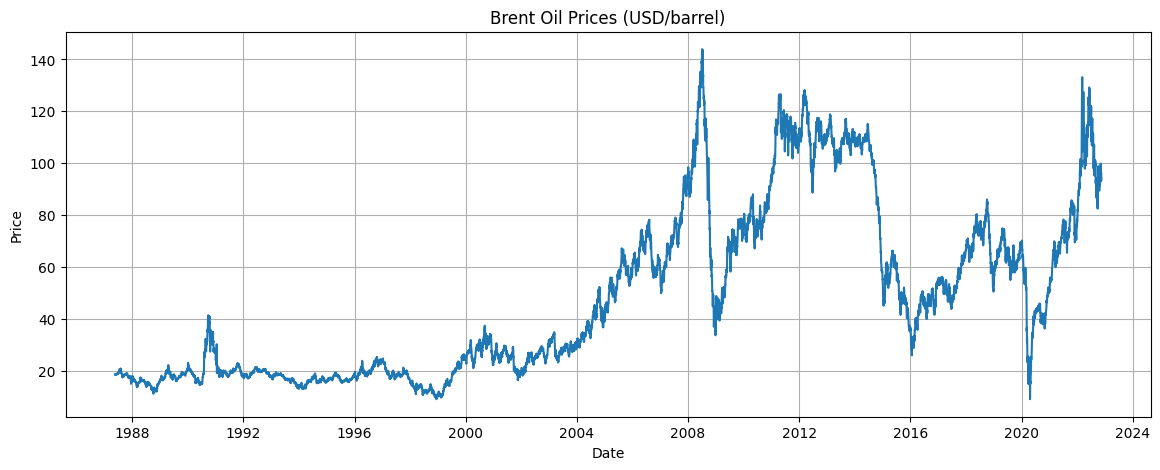

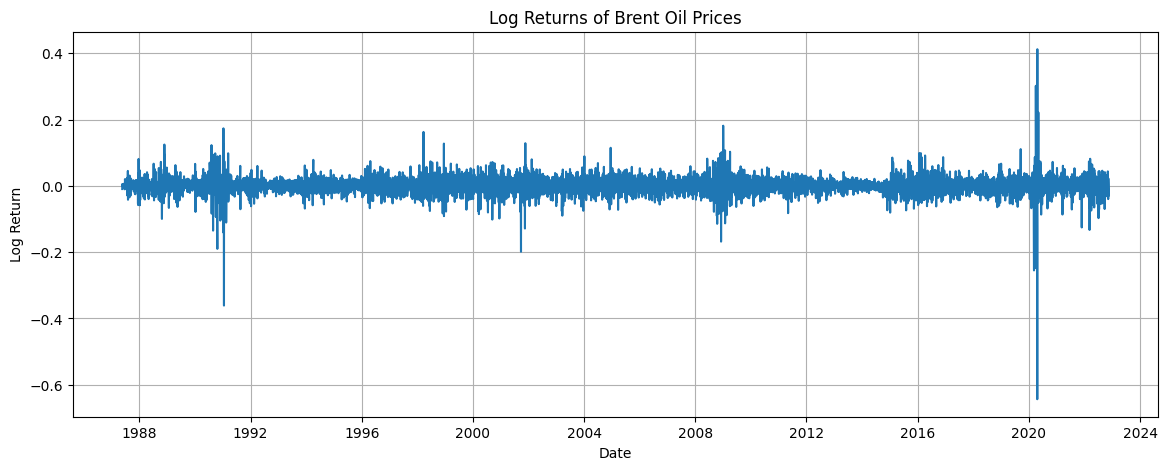

In [6]:
# Plot Raw Prices
plt.figure(figsize=(14, 5))
plt.plot(df['Date'], df['Price'])
plt.title('Brent Oil Prices (USD/barrel)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Compute log returns
df['log_return'] = np.log(df['Price']) - np.log(df['Price'].shift(1))

# Plot Log Returns
plt.figure(figsize=(14, 5))
plt.plot(df['Date'], df['log_return'])
plt.title('Log Returns of Brent Oil Prices')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.grid(True)
plt.show()

# Drop NaNs created by shift
df = df.dropna()


# Bayesian Change Point Model (PyMC3)

In [7]:
log_returns = df['log_return'].values
n = len(log_returns)

with pm.Model() as model:
    # Prior for the change point
    tau = pm.DiscreteUniform('tau', lower=0, upper=n-1)

    # Priors for mean and std before/after
    mu1 = pm.Normal('mu1', mu=0, sigma=1)
    mu2 = pm.Normal('mu2', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Switch logic
    mu = pm.math.switch(tau >= np.arange(n), mu1, mu2)

    # Likelihood
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=log_returns)

    # Inference
    trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


# Analyze and Interpret the Model Output

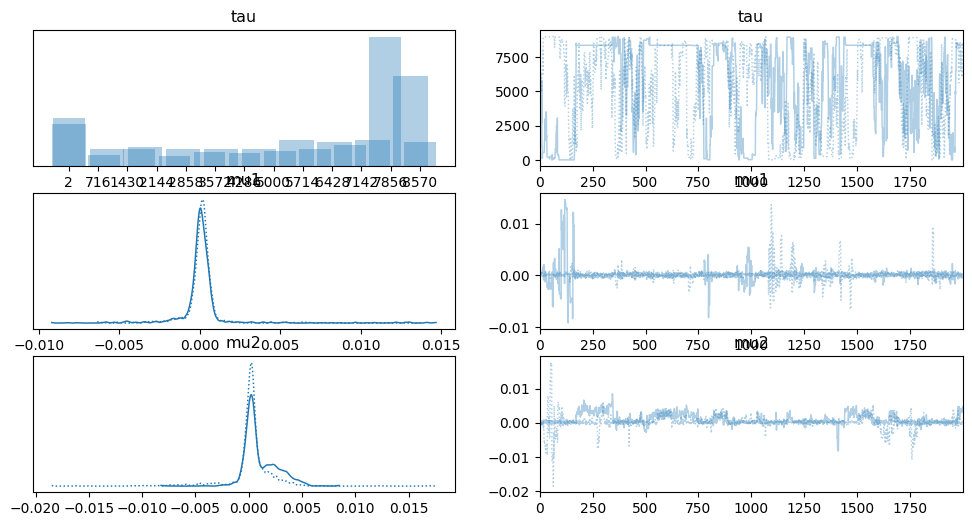

<Axes: title={'center': 'tau'}>

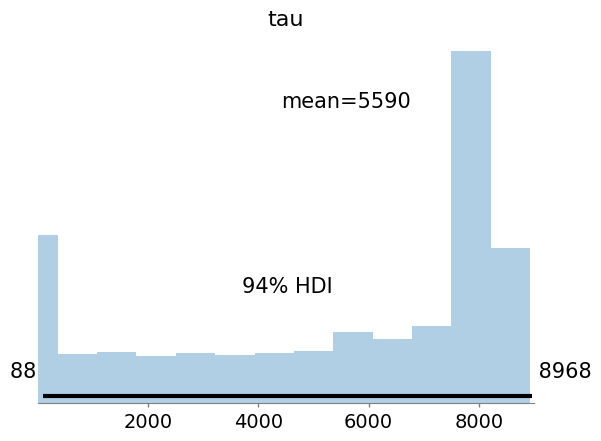

In [8]:
# Trace plots show how well the model sampled
az.plot_trace(trace, var_names=['tau', 'mu1', 'mu2'])
plt.show()

# Posterior distribution of change point
az.plot_posterior(trace, var_names=['tau'])


# Identify the Change Point Date

In [9]:
# Get most probable change point
tau_samples = trace.posterior['tau'].values.flatten()
tau_mode = np.bincount(tau_samples).argmax()

change_date = df.iloc[tau_mode]['Date']
print(f"Most probable change point date: {change_date}")

Most probable change point date: 2020-04-21 00:00:00


# Quantifying Impact

In [10]:
mu1_samples = trace.posterior['mu1'].values.flatten()
mu2_samples = trace.posterior['mu2'].values.flatten()

mean_before = np.mean(mu1_samples)
mean_after = np.mean(mu2_samples)

percent_change = ((mean_after - mean_before) / abs(mean_before)) * 100
print(f"Mean log return shifted from {mean_before:.5f} to {mean_after:.5f}, a change of {percent_change:.2f}%")


Mean log return shifted from 0.00014 to 0.00063, a change of 342.74%


# Compare with Real-World Events

In [11]:
# Load manually compiled event list
events_df = pd.read_csv('/content/drive/MyDrive/events_data.csv')
events_df['Event Date'] = pd.to_datetime(events_df['Event Date'])

# Find closest event
events_df['days_diff'] = abs(events_df['Event Date'] - change_date)
events_df.sort_values('days_diff').head(1)


,Event Date,Event Name,Event Description,Category,days_diff
10,2020-04-20,Negative Oil Prices,WTI oil futures close negative for the first time,Economic Shock,1 days
